<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/9_ResNetsandHigherReceptiveFields/experiments/CIFAR10_Image_Classification_CustomResnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch-lr-finder
!pip install hiddenlayer

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-r_fc17fs
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-r_fc17fs
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98530 sha256=451762501437482527a7e4fd7edca71d91a5159e4497aeff9d6dd5821dbb0879
  Stored in directory: /tmp/pip-ephem-wheel-cache-pal19fla/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# !git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/Cifar10_Resnet/session9/torch_cv_wrapper

In [ ]:
%cd "/content/drive/MyDrive/Cifar10_Resnet/session9/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import customresnet
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/Cifar10_Resnet/session9


## Load config file

In [ ]:
config = helper.process_config("/content/drive/MyDrive/Cifar10_Resnet/session9/session9.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'CIFAR10AlbumentationS9'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'Cifar10DataLoader'},
 'lr_scheduler': 'OneCycleLR',
 'model': 'CustomResnet',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'cifar10_with_customresnet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr': 0.001}, 'type': 'optim.SGD'},
 'training_params'

## Create Training Instance

In [ ]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download data and view sample images

In [ ]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


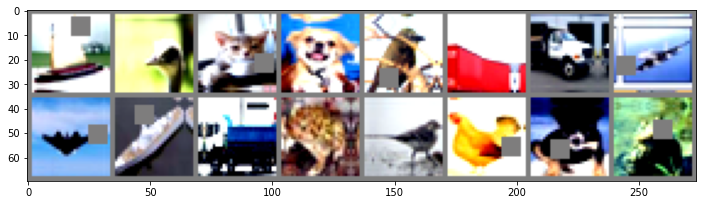

In [ ]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

## Model Summary

In [ ]:
model = customresnet.CustomResNet()
model.to(device)
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

## Visualize Network Architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


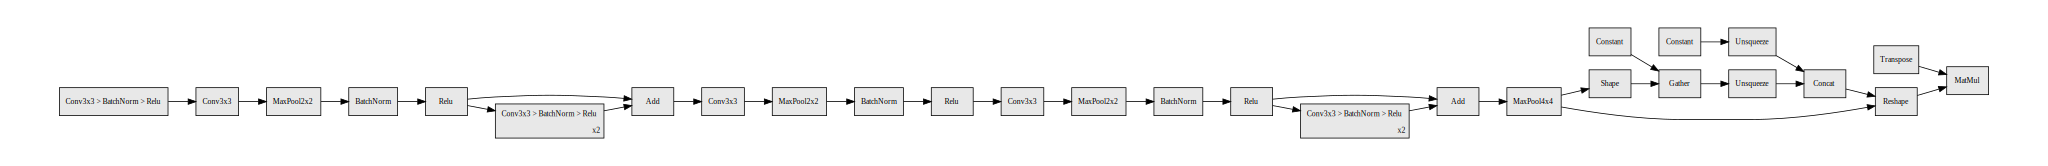

In [ ]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 32, 32])
hl.build_graph(model, input.to(device))

## Find Best LR


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.22E-02


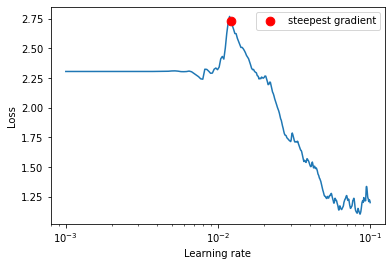

In [ ]:
start_lr = 1e-3
end_lr = 0.2

from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.95,weight_decay=0.005)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=end_lr, num_iter=num_iterations, step_mode="linear")
        
# Plot
best_lr = lr_finder.plot(suggest_lr=True,skip_start=0, skip_end=0)

max_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(
            lr_finder.best_loss)]

# Reset graph
lr_finder.reset()

# lrmax= trigger_training.find_lr(model,train_loader, test_loader, start_lr, end_lr, num_iterations)

In [ ]:
max_lr,best_lr

(0.08585714285714285,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f213aba3410>,
  0.012165413533834588))

## Trigger training

In [ ]:
# trigger_training.
lrmax=max_lr
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader,lrmax)

  0%|          | 0/98 [00:00<?, ?it/s]

using OneCycleLR
Epoch 1:


Loss=1.1915819644927979 Batch_id=97 LR=0.01599 Accuracy=41.53: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5445/10000 (54.45%)

Epoch 2:


Loss=1.1589689254760742 Batch_id=97 LR=0.03538 Accuracy=58.85: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 5711/10000 (57.11%)

Epoch 3:


Loss=1.345776915550232 Batch_id=97 LR=0.05930 Accuracy=66.18: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6909/10000 (69.09%)

Epoch 4:


Loss=0.9185886383056641 Batch_id=97 LR=0.07859 Accuracy=71.19: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7117/10000 (71.17%)

Epoch 5:


Loss=0.5495705604553223 Batch_id=97 LR=0.08586 Accuracy=76.88: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7498/10000 (74.98%)

Epoch 6:


Loss=0.5529621839523315 Batch_id=97 LR=0.08527 Accuracy=79.90: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 8033/10000 (80.33%)

Epoch 7:


Loss=0.6018416285514832 Batch_id=97 LR=0.08353 Accuracy=82.86: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7635/10000 (76.35%)

Epoch 8:


Loss=0.3563907742500305 Batch_id=97 LR=0.08070 Accuracy=84.70: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8389/10000 (83.89%)

Epoch 9:


Loss=0.39728495478630066 Batch_id=97 LR=0.07685 Accuracy=86.36: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8661/10000 (86.61%)

Epoch 10:


Loss=0.32410281896591187 Batch_id=97 LR=0.07209 Accuracy=87.35: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8661/10000 (86.61%)

Epoch 11:


Loss=0.2597026824951172 Batch_id=97 LR=0.06654 Accuracy=88.74: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8707/10000 (87.07%)

Epoch 12:


Loss=0.31342780590057373 Batch_id=97 LR=0.06036 Accuracy=90.07: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8738/10000 (87.38%)

Epoch 13:


Loss=0.2605073153972626 Batch_id=97 LR=0.05372 Accuracy=90.75: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8634/10000 (86.34%)

Epoch 14:


Loss=0.23399707674980164 Batch_id=97 LR=0.04680 Accuracy=91.71: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8899/10000 (88.99%)

Epoch 15:


Loss=0.19775208830833435 Batch_id=97 LR=0.03978 Accuracy=92.23: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8882/10000 (88.82%)

Epoch 16:


Loss=0.2280745506286621 Batch_id=97 LR=0.03286 Accuracy=93.32: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8926/10000 (89.26%)

Epoch 17:


Loss=0.13589589297771454 Batch_id=97 LR=0.02622 Accuracy=93.86: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9035/10000 (90.35%)

Epoch 18:


Loss=0.13227982819080353 Batch_id=97 LR=0.02005 Accuracy=94.60: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9035/10000 (90.35%)

Epoch 19:


Loss=0.1482982486486435 Batch_id=97 LR=0.01452 Accuracy=95.33: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9084/10000 (90.84%)

Epoch 20:


Loss=0.09355807304382324 Batch_id=97 LR=0.00978 Accuracy=96.16: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9127/10000 (91.27%)

Epoch 21:


Loss=0.04937028884887695 Batch_id=97 LR=0.00595 Accuracy=97.02: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9189/10000 (91.89%)

Epoch 22:


Loss=0.055079180747270584 Batch_id=97 LR=0.00314 Accuracy=97.47: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9207/10000 (92.07%)

Epoch 23:


Loss=0.06699730455875397 Batch_id=97 LR=0.00143 Accuracy=97.89: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9219/10000 (92.19%)

Epoch 24:


Loss=0.03999176248908043 Batch_id=97 LR=0.00086 Accuracy=98.11: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 0.0005, Accuracy: 9237/10000 (92.37%)



## Missclassification

Total wrong predictions are 763
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


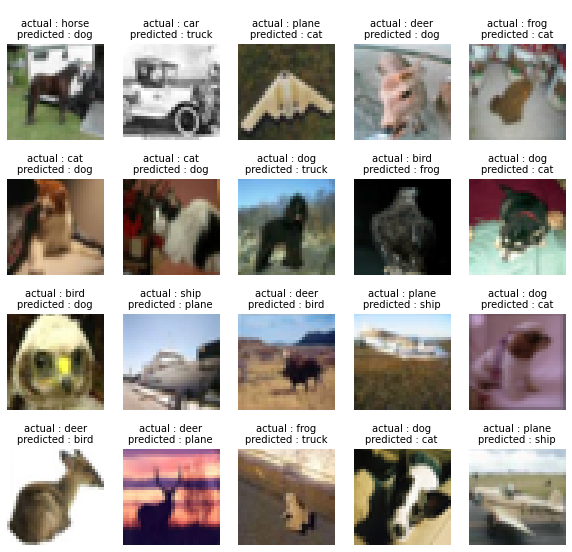

In [ ]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader)

## Plots for Validation Loss and Accuracy

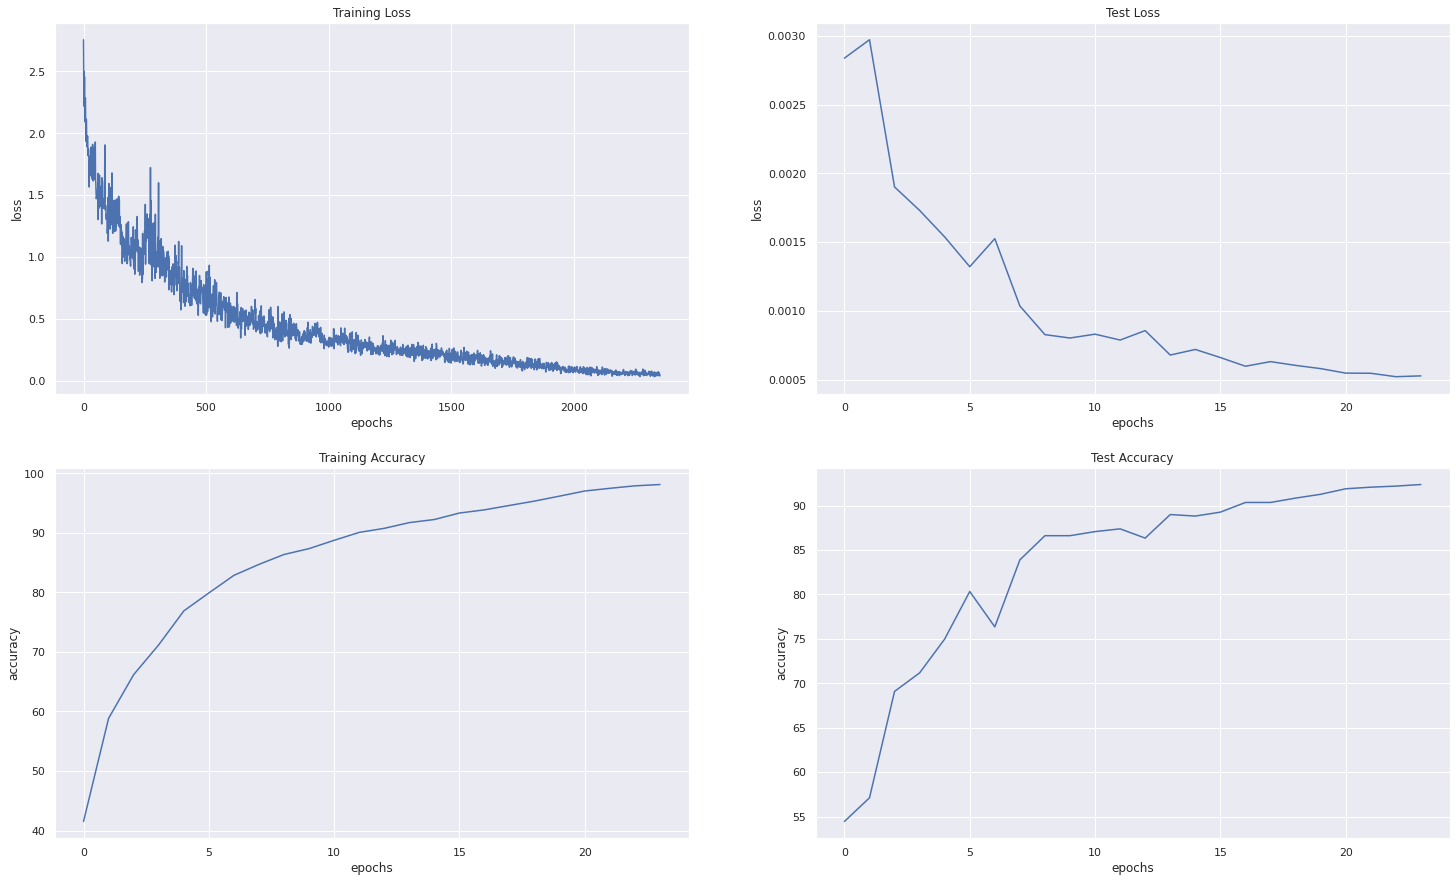

In [ ]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 95 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 82 %
Accuracy of  deer : 91 %
Accuracy of   dog : 89 %
Accuracy of  frog : 95 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %


## Plot Confusion Matrix

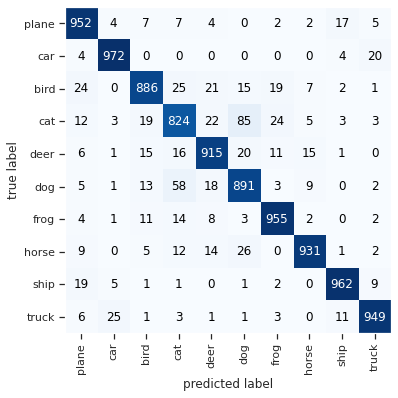

In [ ]:
mat = helper.compute_confusion_matrix(model,test_loader,device)
plot_metrics.plot_confusion_matrix(mat, class_names=classes)


## Generate & Plot GradCam Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


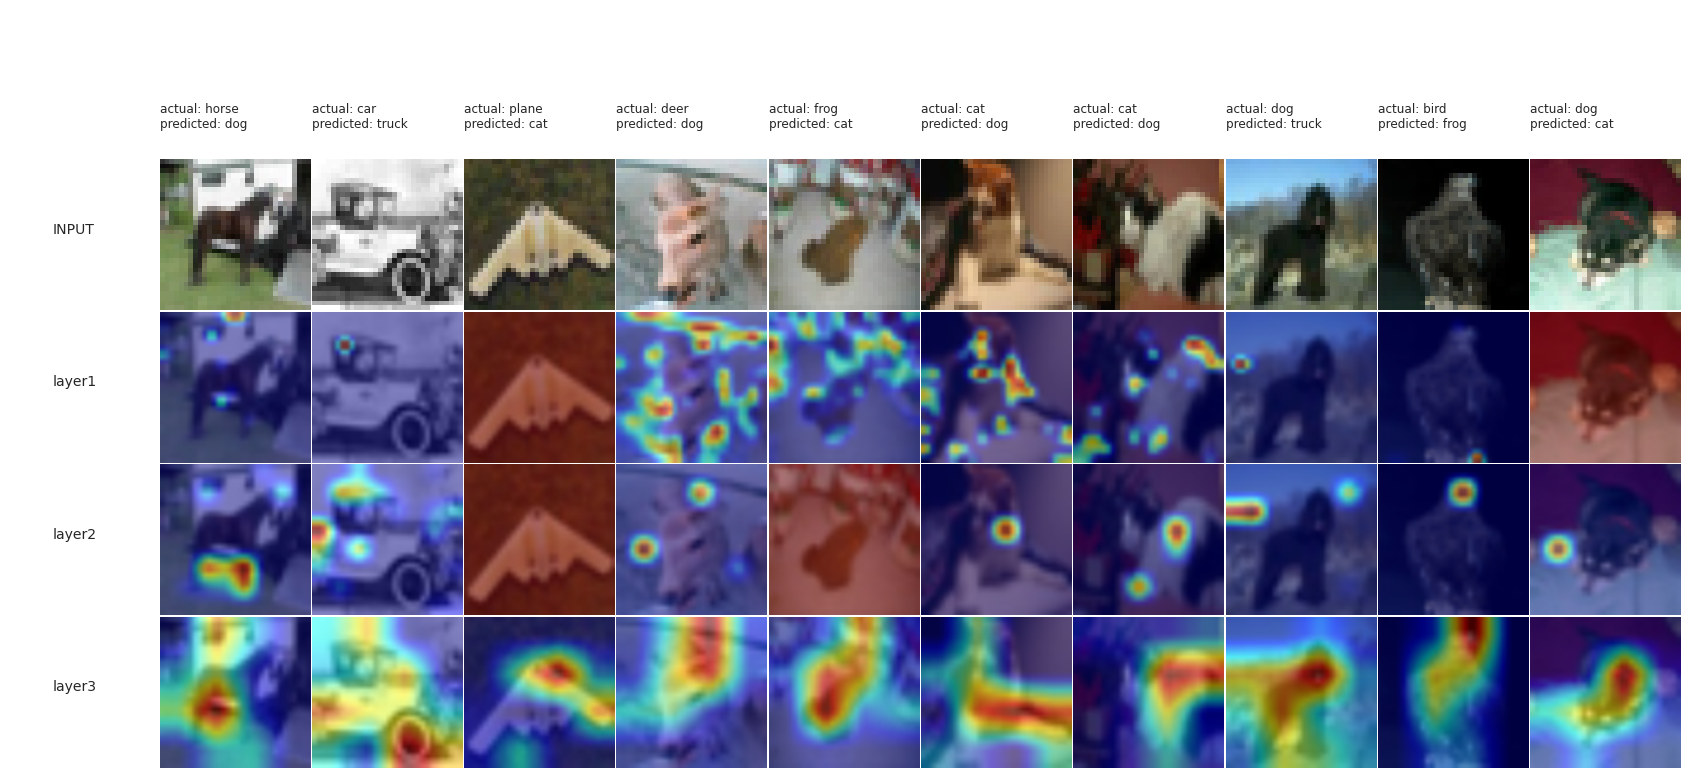

In [ ]:
target_layers = ["layer1","layer2","layer3"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10])

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir=runs